<img src="img/vs265header.svg"/>

<h1 align="center"> Lab 1 - Neuron Models <font color="red"> [SOLUTIONS] </font> </h1> 

In [3]:
# Tianjiao Zhang, 26960050
# PARTNERS: YOUR PARTNERS HERE
%matplotlib notebook
import pdb
import numpy as np
import matplotlib.pyplot as plt
from utils.lab1_utils import PlotterOne

## 1. Membrane model 

Simulate the RC circuit of the cell membrane to determine how the voltage across the membrane will change in response to a step input current, $I(t)$. Start off by deriving the solution for V(t) from the membrane equation. Then, numerically simulate this solution for a duration of 500 milliseconds with the following parameters:
- Initial Voltage Condition: $V(0) = V_{Leak} = -70 mV$
- Membrane Capacitance: $C_m = 100 pF$
- $ I(t) =
\begin{cases}
100 pA & \text{if  } 0 \leq t \leq 150\\
0 \text{ }pA & \text{otherwise}
\end{cases}
$
- Two different leak conductances: $G_{Leak} = $ (i) $5 nS$, and (ii) $10 nS$.

Plot the results of your simulation. Explain how the different values of $G_{Leak}$ affect the time constant and membrane voltage in your simulation and graph.

<IPython.core.display.Javascript object>


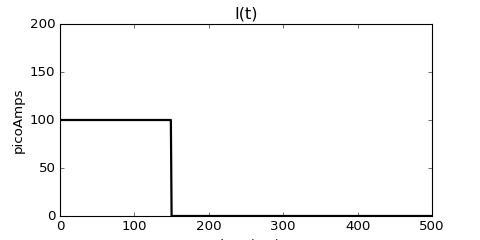

In [4]:
height = 100; stepLength = 150; totalLength = 500
I = np.array([height]*stepLength + [0]*(totalLength-stepLength+1))
plotterOne = PlotterOne(height, totalLength)
plotterOne.plotCurrent(I)

** YOUR TEXT HERE - Derive the solution for V(t) **

<IPython.core.display.Javascript object>


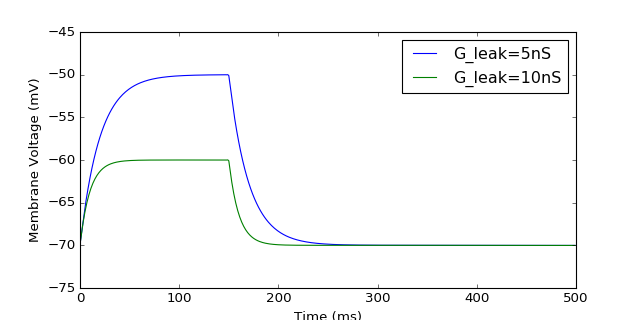

In [5]:
VLeak      = -70 * 1e-3 #mV
CMembrane  = 100 * 1e-12 #pF
plt.figure(figsize=(8,4))
from scipy import signal

def current(time:float) -> float:
    """
    Current input function
    @param time          time (seconds)
    @return float        current at time
    """
    if time <= 150e-3:
        return 100e-12;
    else:
        return 0;

def dV(V:float, time:float, V_leak:float, C_membrane:float, G_leak:float) -> float:
    """
    Function to define dV/Dt
    @param V           membrane voltage at current time (Volts)
    @param time        time at which to evaluate (seconds)
    @param V_leak      leak potential (Volts)
    @param C_membrane  memebran capacitance (Farads)
    @param G_leak      leak conductance (siemens)
    @return float      dV/dt (Volts/seconds)
    """
    return G_leak / C_membrane * (V_leak - V + current(time) / G_leak)

def rk4(function, V_init:float, t_start:float, t_end:float, stepSize:float, G_leak:float, V_leak:float = VLeak, C_membrane:float = CMembrane) -> []: #float[]
    """
    4th order Runge-Kutta numerical solver for V using dV/dt
    @param function           diffeq to evaluate
    @param V_init             initial V
    @param t_start            time to start at
    @param t_end              time to end
    @param stepSize           size of delta-T
    @param G_leak             membrance conductivity to use
    @return float[]           V(t)
    """
    import numpy
    nSteps = int((t_end - t_start) / stepSize)
    output = numpy.zeros([nSteps])
    output[0] = V_init
    # print('integrating over {:d} steps'.format(nSteps))
    time = 0
    for i in range(nSteps - 1):
        Vnow = output[i]
        k1 = stepSize * function(Vnow, time, V_leak, C_membrane, G_leak)
        k2 = stepSize * function(Vnow + k1 / 2, time + stepSize / 2, V_leak, C_membrane, G_leak)
        k3 = stepSize * function(Vnow + k2 / 2, time + stepSize / 2, V_leak, C_membrane, G_leak)
        k4 = stepSize * function(Vnow + k3, time + stepSize, V_leak, C_membrane, G_leak)
        output[i + 1] = Vnow + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
        time += stepSize
    return output    

for GLeak in (5,10):
    VMembrane = [];
    VMembrane = rk4(dV, VLeak, 0, 500e-3, 5e-7, GLeak * 1e-9)
    VMembrane = signal.resample(VMembrane, 500) * 1e3
    plotterOne.plotMembraneVoltage(VMembrane, GLeak)

** YOUR TEXT HERE - Explain your results **

## 2. Shunting Inhibition

Now let’s investigate the non-linear interactions that occur as a result of shunting inhibition. Consider a local compartment with sodium and chloride channels (in addition to $G_{Leak}= 5 nS$, and assume $V_{Leak}$ = -70 $mV$). First write down the membrane equation at equilibrium. Next, plot how the membrane voltage will change as you increase the sodium channel conductance alone, with the chloride channel closed. Then do the same for the chloride channel conductance, with the sodium channel closed. Finally, in a second plot, keep the chloride channel at a fixed conductance ($G_{Cl} = 10nS$) and increase the sodium channel conductance. What happens? How does this compare to what you expect from a linear superposition (plot this as a dashed line). Explain your results in terms of how $G_{Na}$ and $G_{Cl}$ affect the equilibrium membrane equation you wrote earlier.

$\displaystyle V_{SS} = \frac{V_{leak}\;G_{leak} + V_{Na}\;\Delta\;G_{Na} + V_k\;\Delta\;G_k + V_{Cl}\;\Delta\;G_{Cl}}{G_{leak} + \Delta\;G_{Na} + \Delta\;G_k + \Delta\;G_{Cl}}$

In [6]:
from utils.lab1_utils import PlotterTwo

In [7]:
def computeVoltage(GNa:float, GCl:float, V_leak:float = -70e-3, G_leak:float = 5e-9, V_Na:float = 55e-3, V_k:float = -92e-3, G_k:float = 0, V_Cl:float = -65e-3) -> float:
    """
    Computes the steady-state voltage for a set of parameters
    @param GNa         Na+ conductivity (siemens)
    @param GCl         Cl- conductivity (siemens)
    @param V_leak      Leak potential (Volts)
    @param G_leak      leak conductivity (siemens)
    @param V_Na        Na+ nernst potential (Volts)
    @param V_k         K++ nernst potential (Volts)
    @param G_k         K++ conductivity (siemens)
    @param V_Cl        Cl- nernst potential (Volts)
    @return steady state voltage (Volts)
    """
    return (V_leak * G_leak + V_Na * GNa + V_k * G_k + V_Cl * GCl) / (G_leak + GNa + G_k + GCl)

<IPython.core.display.Javascript object>


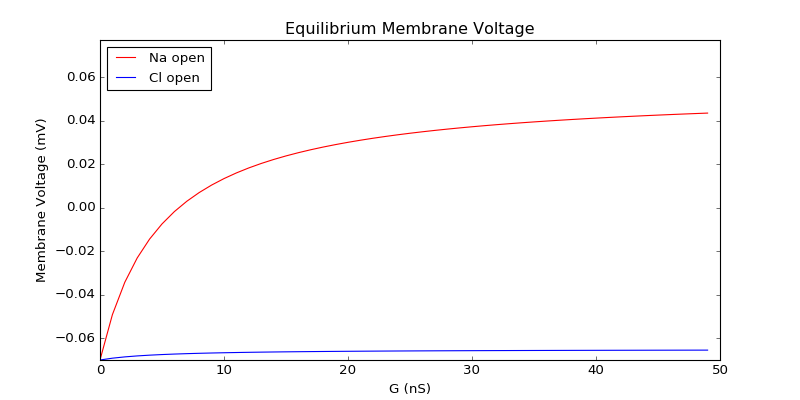

In [20]:
VLeak = -70e-3
VNa = 55e-3
VCl = -65e-3
CMembrane = 100e-12
GLeak = 5e-9
GClFixed = 10e-9

GMax = 50
plotterTwo = PlotterTwo(GMax, VLeak, VNa)

VMemNa = np.zeros(GMax) # Results for opening the Sodium channel
VMemCl = np.zeros(GMax) # Results for opening Chloride channel
VMemNaCl = np.zeros(GMax) # Results for opening Sodium at fixed GCl
VMemLinearNaCl = np.zeros(GMax) # Results for linear prediction
for G in range(GMax):
    VMemNa[G] = computeVoltage(G * 1e-9, 0)# * 1e3
    VMemCl[G] = computeVoltage(0, G * 1e-9) #* 1e3
    VMemNaCl[G] = computeVoltage(G * 1e-9, GClFixed) #* 1e3
    VMemLinearNaCl[G] = computeVoltage(G * 1e-9, 0) + computeVoltage(0, GClFixed)

plotterTwo.plotEqMembraneVoltage(VMemNa, VMemCl)

<IPython.core.display.Javascript object>


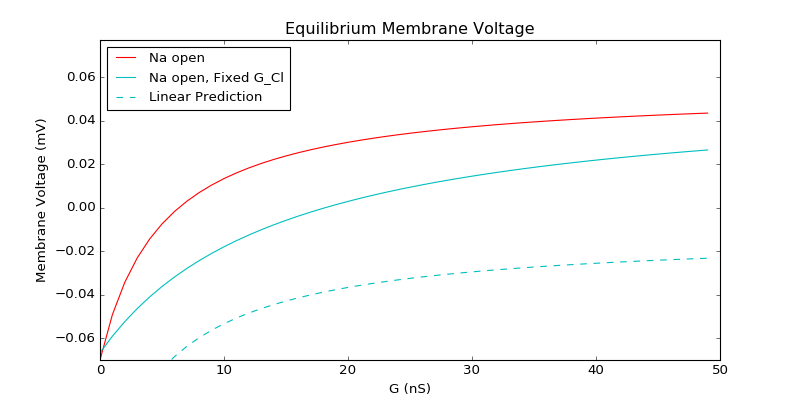

In [21]:
plotterTwo.plotEqMembraneVoltagePrediction(VMemNa, VMemNaCl, VMemLinearNaCl)

** YOUR TEXT HERE - Explain your results **

In [12]:
VMemNa

array([-70.        , -49.16666667, -34.28571429, -23.125     ,
       -14.44444444,  -7.5       ,  -1.81818182,   2.91666667,
         6.92307692,  10.35714286,  13.33333333,  15.9375    ,
        18.23529412,  20.27777778,  22.10526316,  23.75      ,
        25.23809524,  26.59090909,  27.82608696,  28.95833333,
        30.        ,  30.96153846,  31.85185185,  32.67857143,
        33.44827586,  34.16666667,  34.83870968,  35.46875   ,
        36.06060606,  36.61764706,  37.14285714,  37.63888889,
        38.10810811,  38.55263158,  38.97435897,  39.375     ,
        39.75609756,  40.11904762,  40.46511628,  40.79545455,
        41.11111111,  41.41304348,  41.70212766,  41.97916667,
        42.24489796,  42.5       ,  42.74509804,  42.98076923,
        43.20754717,  43.42592593])